<a href="https://colab.research.google.com/github/alanfiga/Neural_Networks_USON/blob/main/RNN-LSTM_DOGECOIN_REDES_NEURONALES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RNN - LSTM: DOGECOIN**

*Configuración Inicial*

In [ ]:
!pip install tensorflow-gpu==2.4.1

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [ ]:
csv_path = 'doge.csv'

In [ ]:
df = pd.read_csv(csv_path, parse_dates=['date'])

In [ ]:
df = df.sort_values('date')

In [ ]:
df.head()

,date,close
1826,2016-05-12,0.000235
1825,2016-05-13,0.000236
1824,2016-05-14,0.000231
1823,2016-05-15,0.000231
1822,2016-05-16,0.000229


In [ ]:
df.shape

(1827, 2)

Text(0.5, 1.0, 'DOGECOIN')

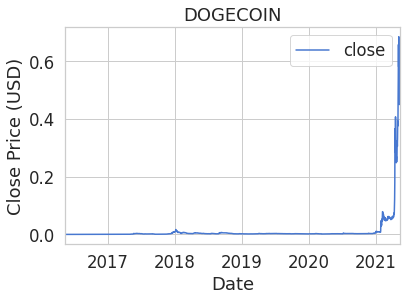

In [ ]:
ax = df.plot(x='date', y='close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
ax.set_title("DOGECOIN")

*NORMALIZACIÓN*

In [ ]:
scaler = MinMaxScaler()

close_price = df.close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close.shape

(1827, 1)

In [ ]:
np.isnan(scaled_close).any()

False

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [ ]:
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
np.isnan(scaled_close).any()

False

*PREPROCESAMIENTO*

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [ ]:
X_train.shape

(1640, 99, 1)

In [ ]:
X_test.shape

(87, 99, 1)

*MODELO*

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))



*ENTRENAMIENTO*

In [ ]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 99, 198)           79992     
_________________________________________________________________
dropout (Dropout)            (None, 99, 198)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 99, 396)           628848    
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 396)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 198)               392832    
_________________________________________________________________
dense (Dense)                (None, 1)                 199       
_________________________________________________________________
activation (Activation)      (None, 1)                

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)


Epoch 1/50
24/24 [==============================] - 56s 2s/step - loss: 2.2685e-04 - val_loss: 6.5169e-04
Epoch 2/50
24/24 [==============================] - 43s 2s/step - loss: 1.4033e-05 - val_loss: 5.4743e-04
Epoch 3/50
24/24 [==============================] - 44s 2s/step - loss: 3.2765e-05 - val_loss: 5.5749e-04
Epoch 4/50
24/24 [==============================] - 44s 2s/step - loss: 2.7262e-05 - val_loss: 5.7242e-04
Epoch 5/50
24/24 [==============================] - 43s 2s/step - loss: 1.2854e-05 - val_loss: 5.3593e-04
Epoch 6/50
24/24 [==============================] - 44s 2s/step - loss: 1.2026e-05 - val_loss: 4.9530e-04
Epoch 7/50
24/24 [==============================] - 45s 2s/step - loss: 1.5838e-05 - val_loss: 4.8526e-04
Epoch 8/50
24/24 [==============================] - 45s 2s/step - loss: 1.3419e-05 - val_loss: 4.4196e-04
Epoch 9/50
24/24 [==============================] - 43s 2s/step - loss: 1.4783e-05 - val_loss: 4.3613e-04
Epoch 10/50
24/24 [===========================

In [ ]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 311ms/step - loss: 0.0349


0.03485806658864021

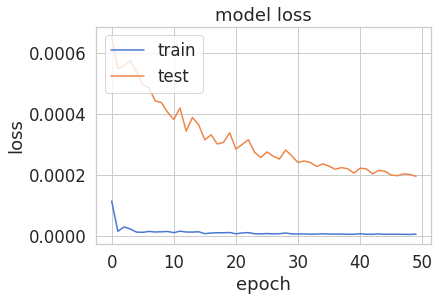

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

*PREDICCIÓN*

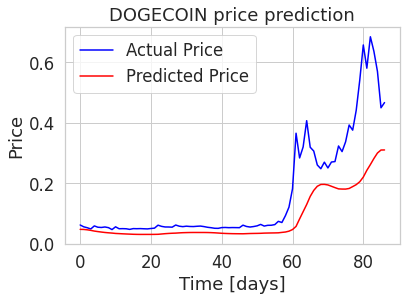

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='blue')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('DOGECOIN price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();